## Autoencoder

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.” Autoencoders can be used for image denoising, image compression, and, in some cases, even generation of image data.

## Flow of Autoencoder

Noisy Image -> Encoder -> Compressed Representation -> Decoder -> Reconstruct Clear Image

## Import Modules

In [138]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Add, Input
from keras.datasets import mnist

# Enable GPU

In [139]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [140]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split

# Path to the parent directory where numbered folders exist
base_dir = "/Users/yfahmy/Downloads/mini-english-01-package"  # Change this to your actual data path
image_dim = 128

# Initialize lists for images and labels
images = []

# Iterate over folder numbers from 1 to 9999
for folder_num in range(1, 10000):  # 1 to 9999
    folder_path = os.path.join(base_dir, str(folder_num))
    image_path = os.path.join(folder_path, "01.jpg")

    # Check if the image exists
    if os.path.exists(image_path):
        try:
            img = Image.open(image_path).convert("RGB")  # Convert to RGB
            img = img.resize((image_dim, image_dim))  # Resize for consistency

            images.append(np.array(img))  # Convert to NumPy array
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

# Convert lists to NumPy arrays
images = np.array(images)

# Split data into training (80%) and testing (20%)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)
# normalize the image data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# reshape in the input data for the model
x_train = x_train.reshape(len(x_train), image_dim, image_dim, 3)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, 3)

# Print dataset shapes
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (7736, 128, 128, 3), x_test shape: (1935, 128, 128, 3)


## Add Noise to the Image

In [141]:
# add noise
noise_factor = 0.075
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [142]:
# clip the values in the range of 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Exploratory Data Analysis

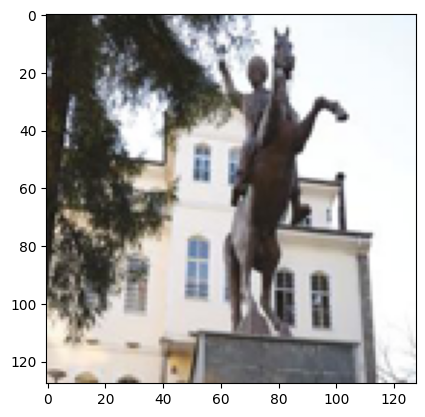

In [143]:
index = 101
# plot the image
plt.imshow(x_test[index].reshape(image_dim,image_dim,3))
plt.show()

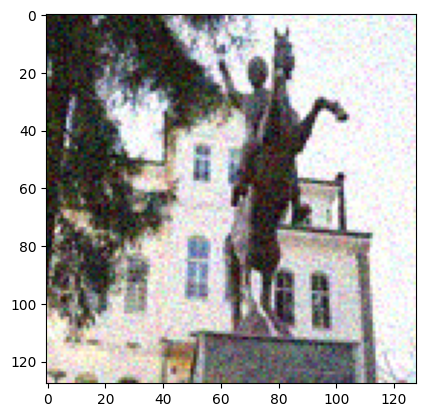

In [144]:
# plot the image
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
plt.show()

## Model Creation

In [145]:
input_img = Input(shape=(image_dim, image_dim, 3))  # RGB images

# First layer (Conv + ReLU)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

# Intermediate layers (Conv + BN + ReLU)
for _ in range(6):  # Repeat (D-2) times
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Last layer (Conv, No Activation)
x = Conv2D(3, (3, 3), padding='same')(x)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, x])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_98[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_99[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 128, 128,  │     36,928 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_100[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 128, 128,  │     36,928 │ re_lu_10[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_101[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 128, 128,  │     36,928 │ re_lu_11[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_102[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 128, 128,  │     36,928 │ re_lu_12[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_103[0][0]

 Total params: 226,627 (885.26 KB)

 Trainable params: 225,859 (882.26 KB)

 Non-trainable params: 768 (3.00 KB)

In [146]:
print("Training data shape:", x_train.shape)
print("Batch size:", 256)  # Your batch size

Training data shape: (7736, 128, 128, 3)
Batch size: 256


In [147]:
# train the model
model.fit(x_train_noisy, x_train, epochs=200 , batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/200


2025-03-15 23:25:43.353981: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1995

2025-03-15 23:27:47.914569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


61/61 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - loss: 0.1973 - val_loss: 0.0069
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - loss: 0.0064 - val_loss: 0.0057
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - loss: 0.0056 - val_loss: 0.0053
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - loss: 0.0051 - val_loss: 0.0050
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 0.0048 - val_loss: 0.0050
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 0.0046 - val_loss: 0.0048
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - loss: 0.0043 - val_loss: 0.0046
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 0.0038 - val_loss: 0.0044
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 0.0030 - val_loss: 0.0044
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - loss: 0.0027 - val_loss: 0.0034
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 0.0

## Visualize the Results

In [148]:
# predict the results from model (get compressed images)
pred = model.predict(x_test_noisy)

2025-03-16 06:15:17.537648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


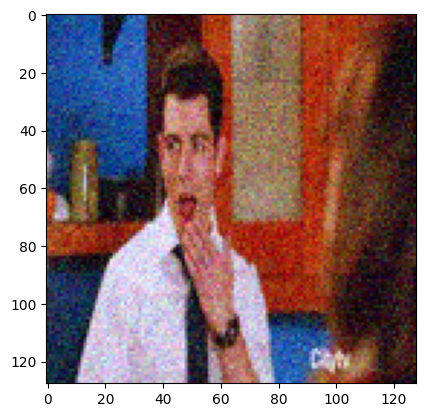

In [149]:
# randomly select input image
index = np.random.randint(len(x_test))
# plot the image
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0031382332..1.0113747].


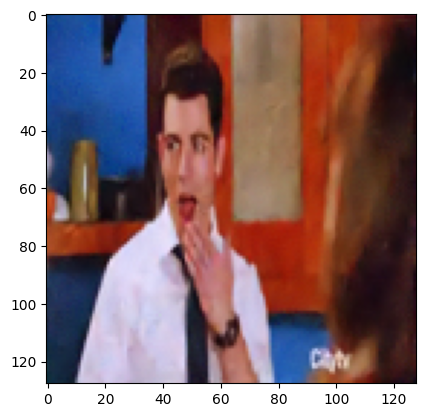

In [150]:
# visualize compressed image
plt.imshow(pred[index].reshape(image_dim,image_dim,3))
plt.gray()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03541496..1.0280817].


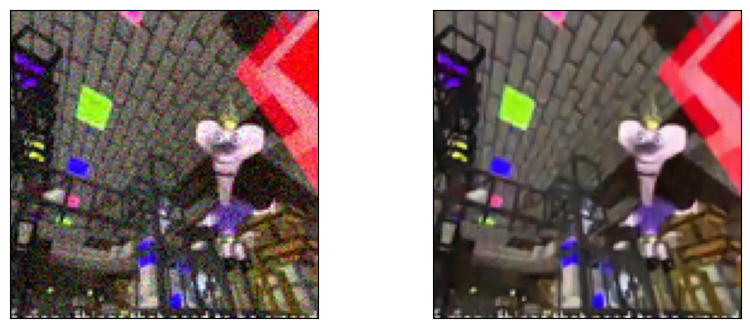

In [151]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(10, 4))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(pred[index].reshape(image_dim,image_dim,3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030685656..0.896417].


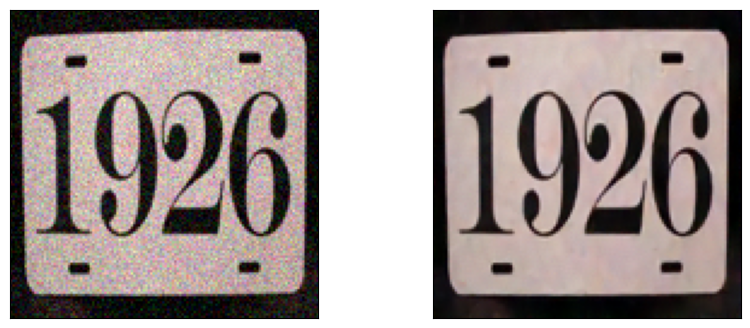

In [152]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(10, 4))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(pred[index].reshape(image_dim,image_dim,3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()